# Doughnut seminar 2023: Introduction to Stan

M D Blackledge

If you would like to run this notebook through collab, then please use the following link:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdblackledge/stan_examples/blob/main/notebooks/doughnut_seminar_2023.ipynb)

## Library installation
First we need to check that all relevant libraries are installed into the Jupyter instance.  Be cautious when installing this on an M1/M2 chip on the Mac.  This should work on a Linux machine or Google colab.

In [1]:
!pip install pystan arviz | grep -v 'already satisfied'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.3 MB/s eta 0:00:00


## Library Import

Import all relevant libraries.  Note that for Stan to work in Jupyter, we also need nest_asyncio!

In [2]:
import nest_asyncio
nest_asyncio.apply()
import httpstan
import stan
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

## Example 1. Basic usage
In this example we will create a very simple model to demonstrate how to estimat the mean and standard deviation of data sampled from a normal distribution:
$$
x_{i} \sim \mathcal{N}(\mu, \sigma)
$$

In this initial example we will assume uniform priors for the mean and standard deviation, though note that these are "improper"!

In [3]:
# Define the model string

simple_model = """
data {
    int<lower = 1> N;
    array[N] real x;
}
parameters {
    real mu;
    real<lower = 0> sigma;
}
model {
    for (n in 1:N) {
        target += normal_lpdf(x[n] | mu, sigma);
    }
}
"""

# Synthesize some data
N = 40
x = np.random.normal(loc = 2.0, scale = 3.0, size = N)

# Build the model.  This will take some time the first time it is run!
model = stan.build(simple_model, data = {"N": N, "x": x})

# Draw some samples
samples = model.sample(num_samples = 5000,  # How many samples to we want?
                       num_warmup = 500,  # How many samples to discard from the beginning?
                       num_chains = 2,  # How many indpendent sample chains do we want? At least 2 for diagnostics!
                       num_thin = 1)  # Do we want to reduce correlations?

Building...



Building: 32.5s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  50% (5500/11000)
Sampling: 100% (11000/11000)
Sampling: 100% (11000/11000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!


## A brief interlude: ArviZ

ArviZ is a power vizualisation library for illustration of Stan fitting results (and other MCMC packages!).  The best way to get started is to use the example gallery for ideas: https://python.arviz.org/en/stable/examples/index.html.

Here we will use ArviZ to:

1. Obtain a better representation of the sampled data
2. Plot the sample traces to visualize whether they are adequate.
3. Display a summary of the the fit, including convergence diagnostic $\widehat{R}$.

### Convert to ArviZ data
ArviZ converts the output pystan samples into something it can use via the `az.from_pystan` function.  The result is an instance of a `Numba` Python package variable, which provides better access to samples from individual chains.

In [4]:
# Convert pystan samples into something arviz can deal with
az_samples = az.from_pystan(samples)
az_samples

Inference data with groups:
	> posterior
	> sample_stats

### Plotting sample traces
It is crucial to investigate the sample traces of your parameters, ideally from 2 or more chains to check that

1. The samples are not correlated.
2. Samples have converged from initial parameter guesses.
3. There is good mixing between chains.

ArviZ provides a basic plotting utility, `az.plot_trace`, that can be used to visualize samples.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


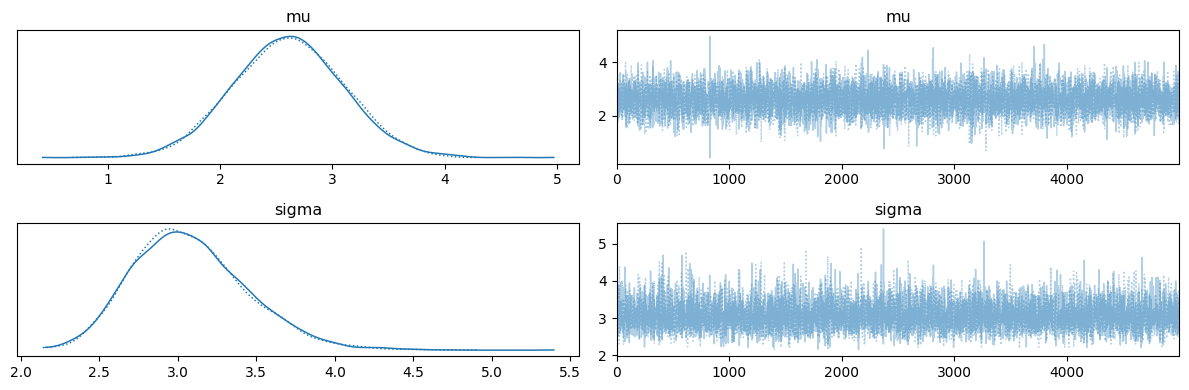

In [5]:
# Display the traces for each chain
az.plot_trace(az_samples)

plt.tight_layout()  # Hint: This always improves layout of results
plt.show()

### Assessing convergence numerically
A summary of the samples can be obtained using

In [6]:
# How good are the convergence diagnostics?
az.summary(az_samples)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,2.606,0.494,1.689,3.536,0.006,0.004,7815.0,5903.0,1.0
sigma,3.076,0.368,2.428,3.764,0.004,0.003,7067.0,6252.0,1.0


## Example dataset
In the following, we use an existing dataset from a previous paper (https://pubmed.ncbi.nlm.nih.gov/34341730/), which explores the difference in ADC statistics between diseased and helthy nodes, as assessed using whole-body DWI.